In [33]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn.inspection import permutation_importance

# Gradient boosting libraries
import xgboost as xgb
import lightgbm as lgb

# NLP libraries
import nltk

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [34]:
# read the preprocessed data
data = pd.read_csv('processed_data/glassdoor_jobs.csv')

In [35]:
data.head()

,job_id,Job Title,Job Description,seniority,company_id,age,Python,R,Spark,AWS,Excel,min_salary,max_salary,avg_salary,employer_provided,num_comp
0,1,Data Scientist,"Data Scientist\nLocation: Albuquerque, NM\nEdu...",na,1,47,1,0,0,0,1,69642.0,119574.0,94608.0,0,0
1,2,Healthcare Data Scientist,What You Will Do:\n\nI. General Summary\n\nThe...,na,2,36,1,0,0,0,0,82782.0,147168.0,114975.0,0,0
2,3,Data Scientist,"KnowBe4, Inc. is a high growth information sec...",na,3,10,1,0,1,0,1,105120.0,118260.0,111690.0,0,0
3,4,Data Scientist,*Organization and Job ID**\nJob ID: 310709\n\n...,na,4,55,1,0,0,0,0,73584.0,127458.0,100521.0,0,3
4,5,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,na,5,22,1,0,0,0,1,113004.0,187902.0,150453.0,0,3


In [36]:
# drop job_id, seniority, company_id, employer_provided, num_comp since these have either too 
# many nan values or dkew the results

data.drop(columns=['job_id', 'seniority', 'company_id', 'employer_provided', 'num_comp'], inplace=True)

In [37]:
data.head()

,Job Title,Job Description,age,Python,R,Spark,AWS,Excel,min_salary,max_salary,avg_salary
0,Data Scientist,"Data Scientist\nLocation: Albuquerque, NM\nEdu...",47,1,0,0,0,1,69642.0,119574.0,94608.0
1,Healthcare Data Scientist,What You Will Do:\n\nI. General Summary\n\nThe...,36,1,0,0,0,0,82782.0,147168.0,114975.0
2,Data Scientist,"KnowBe4, Inc. is a high growth information sec...",10,1,0,1,0,1,105120.0,118260.0,111690.0
3,Data Scientist,*Organization and Job ID**\nJob ID: 310709\n\n...,55,1,0,0,0,0,73584.0,127458.0,100521.0
4,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,22,1,0,0,0,1,113004.0,187902.0,150453.0


### Apply TF-IDF vectorization on job title and job description

In [38]:
# 1. Clean and Represent Textual Data (Job Description and Job Title)
# Use TF-IDF to represent textual data numerically
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
job_desc_tfidf = tfidf_vectorizer.fit_transform(data['Job Description'].fillna('')).toarray()
job_title_tfidf = tfidf_vectorizer.fit_transform(data['Job Title'].fillna('')).toarray()

### Apply SVD on the data
Worse result hence dropped. It only helped a little with Random Forest in all other cases the performance was worse off.

In [39]:

# # Apply SVD for dimensionality reduction
# svd = TruncatedSVD(n_components=100, random_state=42)  # Reduce to 100 dimensions
# job_desc_svd = svd.fit_transform(job_desc_tfidf)

In [40]:
# # Add TF-IDF features back to the DataFrame
job_desc_tfidf_df = pd.DataFrame(job_desc_tfidf, columns=[f'JD_TFIDF_{i}' for i in range(job_desc_tfidf.shape[1])])
job_title_tfidf_df = pd.DataFrame(job_title_tfidf, columns=[f'JT_TFIDF_{i}' for i in range(job_title_tfidf.shape[1])])
data = pd.concat([data.reset_index(drop=True), job_desc_tfidf_df, job_title_tfidf_df], axis=1)

### Trying BERT
Also gave worse results than TF-IDF

In [41]:
# from transformers import BertTokenizer, BertModel
# import torch

# # Load pre-trained BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# # Function to generate BERT embeddings for a text column
# def get_bert_embeddings(texts):
#     inputs = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True, max_length=128)
#     with torch.no_grad():  # Disable gradient calculation for inference
#         outputs = model(**inputs)
#     # Use the CLS token's embedding as the representation for each text
#     return outputs.last_hidden_state[:, 0, :].detach().numpy()

# # Generate BERT embeddings for 'Job Description' and 'Job Title'
# job_desc_embeddings = get_bert_embeddings(data['Job Description'].fillna(''))
# job_title_embeddings = get_bert_embeddings(data['Job Title'].fillna(''))

# # Convert embeddings to DataFrame and add them back to the dataset
# job_desc_df = pd.DataFrame(job_desc_embeddings, columns=[f'JD_BERT_{i}' for i in range(job_desc_embeddings.shape[1])])
# job_title_df = pd.DataFrame(job_title_embeddings, columns=[f'JT_BERT_{i}' for i in range(job_title_embeddings.shape[1])])

# data = pd.concat([data.reset_index(drop=True), job_desc_df, job_title_df], axis=1)

### Normalize all numerica values in the dataset

In [42]:
# 2. Retain and Normalize Numerical Features
# Normalize "age of company" using Min-Max Scaling
scaler = MinMaxScaler()
data['age_of_company_normalized'] = scaler.fit_transform(data[['age']])

In [43]:
# count number of datapoint with avg salary less than 50k
data[data['avg_salary'] < 50000].shape[0]

6

Since its so few datapoints, we decided to exclude these values

In [44]:
# drop all rows where avg_salary is less than 10k
data = data[data['avg_salary'] > 51000]

In [45]:
# Detect and handle outliers in salary columns using IQR method
for col in ['min_salary', 'max_salary', 'avg_salary']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap outliers to the lower and upper bounds
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

In [46]:
data.head()

,Job Title,Job Description,age,Python,R,Spark,AWS,Excel,min_salary,max_salary,...,JT_TFIDF_287,JT_TFIDF_288,JT_TFIDF_289,JT_TFIDF_290,JT_TFIDF_291,JT_TFIDF_292,JT_TFIDF_293,JT_TFIDF_294,JT_TFIDF_295,age_of_company_normalized
0,Data Scientist,"Data Scientist\nLocation: Albuquerque, NM\nEdu...",47,1,0,0,0,1,69642.0,119574.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173285
1,Healthcare Data Scientist,What You Will Do:\n\nI. General Summary\n\nThe...,36,1,0,0,0,0,82782.0,147168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133574
2,Data Scientist,"KnowBe4, Inc. is a high growth information sec...",10,1,0,1,0,1,105120.0,118260.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039711
3,Data Scientist,*Organization and Job ID**\nJob ID: 310709\n\n...,55,1,0,0,0,0,73584.0,127458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202166
4,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,22,1,0,0,0,1,113004.0,187902.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083032


In [47]:
# Drop original text columns to avoid redundancy
data.drop(['Job Description', 'Job Title'], axis=1, inplace=True)
data.head()

,age,Python,R,Spark,AWS,Excel,min_salary,max_salary,avg_salary,JD_TFIDF_0,...,JT_TFIDF_287,JT_TFIDF_288,JT_TFIDF_289,JT_TFIDF_290,JT_TFIDF_291,JT_TFIDF_292,JT_TFIDF_293,JT_TFIDF_294,JT_TFIDF_295,age_of_company_normalized
0,47,1,0,0,0,1,69642.0,119574.0,94608.0,0.031508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173285
1,36,1,0,0,0,0,82782.0,147168.0,114975.0,0.066326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133574
2,10,1,0,1,0,1,105120.0,118260.0,111690.0,0.022098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039711
3,55,1,0,0,0,0,73584.0,127458.0,100521.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202166
4,22,1,0,0,0,1,113004.0,187902.0,150453.0,0.050565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083032


### Defining features and target variables

In [48]:
# Define features and target variables
X = data.drop(columns=['min_salary', 'max_salary', 'avg_salary'])
y_min = data['min_salary']
y_max = data['max_salary']
y_avg = data['avg_salary']

# Split the data into training and testing sets (80-20 split) - 3 splits for models to calculate each of the params
X_train, X_test, y_min_train, y_min_test = train_test_split(X, y_min, test_size=0.2, random_state=42)
X_train, X_test, y_max_train, y_max_test = train_test_split(X, y_max, test_size=0.2, random_state=42)
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X, y_avg, test_size=0.2, random_state=42)

### Linear Regression

In [49]:
linear_model = LinearRegression()
# Train and evaluate Linear Regression for avg_salary
linear_model.fit(X_train, y_avg_train)
y_avg_pred_linear = linear_model.predict(X_test)
linear_metrics = {
    'MAE': mean_absolute_error(y_avg_test, y_avg_pred_linear),
    'MSE': mean_squared_error(y_avg_test, y_avg_pred_linear),
    'R2': r2_score(y_avg_test, y_avg_pred_linear)
}

In [50]:
rf_model = RandomForestRegressor(random_state=42)
# Train and evaluate Random Forest for avg_salary
rf_model.fit(X_train, y_avg_train)
y_avg_pred_rf = rf_model.predict(X_test)
rf_metrics = {
    'MAE': mean_absolute_error(y_avg_test, y_avg_pred_rf),
    'MSE': mean_squared_error(y_avg_test, y_avg_pred_rf),
    'R2': r2_score(y_avg_test, y_avg_pred_rf)
}

In [51]:
xgb_model = xgb.XGBRegressor(random_state=42)
# Train and evaluate XGBoost for avg_salary
xgb_model.fit(X_train, y_avg_train)
y_avg_pred_xgb = xgb_model.predict(X_test)
xgb_metrics = {
    'MAE': mean_absolute_error(y_avg_test, y_avg_pred_xgb),
    'MSE': mean_squared_error(y_avg_test, y_avg_pred_xgb),
    'R2': r2_score(y_avg_test, y_avg_pred_xgb)
}

In [52]:
# Output metrics for all models
print("Linear Regression Metrics:", linear_metrics)
print("Random Forest Metrics:", rf_metrics)
print("XGBoost Metrics:", xgb_metrics)

Linear Regression Metrics: {'MAE': 6377271126821.677, 'MSE': 1.775862072156738e+26, 'R2': -7.974662510024515e+16}
Random Forest Metrics: {'MAE': 18650.923303523166, 'MSE': 738062996.1395246, 'R2': 0.668566416410815}
XGBoost Metrics: {'MAE': 13373.170976562502, 'MSE': 714936853.840143, 'R2': 0.6789514109938906}


In [53]:
linear_model = LinearRegression()
# Train and evaluate Linear Regression for avg_salary
linear_model.fit(X_train, y_min_train)
y_min_pred_linear = linear_model.predict(X_test)
linear_metrics = {
    'MAE': mean_absolute_error(y_min_test, y_min_pred_linear),
    'MSE': mean_squared_error(y_min_test, y_min_pred_linear),
    'R2': r2_score(y_min_test, y_min_pred_linear)
}
rf_model = RandomForestRegressor(random_state=42)
# Train and evaluate Random Forest for avg_salary
rf_model.fit(X_train, y_min_train)
y_min_pred_rf = rf_model.predict(X_test)
rf_metrics = {
    'MAE': mean_absolute_error(y_min_test, y_min_pred_rf),
    'MSE': mean_squared_error(y_min_test, y_min_pred_rf),
    'R2': r2_score(y_min_test, y_min_pred_rf)
}
xgb_model = xgb.XGBRegressor(random_state=42)
# Train and evaluate XGBoost for avg_salary
xgb_model.fit(X_train, y_min_train)
y_min_pred_xgb = xgb_model.predict(X_test)
xgb_metrics = {
    'MAE': mean_absolute_error(y_min_test, y_min_pred_xgb),
    'MSE': mean_squared_error(y_min_test, y_min_pred_xgb),
    'R2': r2_score(y_min_test, y_min_pred_xgb)
}
# Output metrics for all models
print("Linear Regression Metrics:", linear_metrics)
print("Random Forest Metrics:", rf_metrics)
print("XGBoost Metrics:", xgb_metrics)

Linear Regression Metrics: {'MAE': 5708283231542.053, 'MSE': 1.4228217543341433e+26, 'R2': -1.0353744150635099e+17}
Random Forest Metrics: {'MAE': 14964.29109671815, 'MSE': 453272104.179901, 'R2': 0.6701580234486231}
XGBoost Metrics: {'MAE': 10156.132171663852, 'MSE': 407671520.0625196, 'R2': 0.703341152651749}


In [54]:
linear_model = LinearRegression()
# Train and evaluate Linear Regression for avg_salary
linear_model.fit(X_train, y_max_train)
y_max_pred_linear = linear_model.predict(X_test)
linear_metrics = {
    'MAE': mean_absolute_error(y_max_test, y_max_pred_linear),
    'MSE': mean_squared_error(y_max_test, y_max_pred_linear),
    'R2': r2_score(y_max_test, y_max_pred_linear)
}
rf_model = RandomForestRegressor(random_state=42)
# Train and evaluate Random Forest for avg_salary
rf_model.fit(X_train, y_max_train)
y_max_pred_rf = rf_model.predict(X_test)
rf_metrics = {
    'MAE': mean_absolute_error(y_max_test, y_max_pred_rf),
    'MSE': mean_squared_error(y_max_test, y_max_pred_rf),
    'R2': r2_score(y_max_test, y_max_pred_rf)
}
xgb_model = xgb.XGBRegressor(random_state=42)
# Train and evaluate XGBoost for avg_salary
xgb_model.fit(X_train, y_max_train)
y_max_pred_xgb = xgb_model.predict(X_test)
xgb_metrics = {
    'MAE': mean_absolute_error(y_max_test, y_max_pred_xgb),
    'MSE': mean_squared_error(y_max_test, y_max_pred_xgb),
    'R2': r2_score(y_max_test, y_max_pred_xgb)
}
# Output metrics for all models
print("Linear Regression Metrics:", linear_metrics)
print("Random Forest Metrics:", rf_metrics)
print("XGBoost Metrics:", xgb_metrics)

Linear Regression Metrics: {'MAE': 7046259021744.405, 'MSE': 2.1679870179603444e+26, 'R2': -6.8603010530408024e+16}
Random Forest Metrics: {'MAE': 22944.417531949806, 'MSE': 1139433138.6694882, 'R2': 0.6394418280032865}
XGBoost Metrics: {'MAE': 14794.82369510135, 'MSE': 928452269.4023288, 'R2': 0.7062038642892176}


### Extensive analysis to generate a report with model variance, extreme error, k-fold and multiple configuration analysis
After trying out various models and pre processing techniques it can be seen that XGBoost seems to perform the best. Looking at this result now we also see look into LGB and Ridge regression models and their performance.

### Enhanced Evaluation Function with K-Fold Cross-Validation

In [55]:
def evaluate_model_kfold(model, X, y, model_name="Model", k=5, random_state=42):
    """
    Evaluate a regression model using k-fold cross-validation with focus on
    adjusted MAE (10% tolerance) and within-10% accuracy metrics.
    
    Parameters:
    -----------
    model : sklearn or compatible model object
        The model to evaluate
    X : pandas DataFrame
        Features
    y : pandas Series
        Target values
    model_name : str, default="Model"
        Name of the model for reporting
    k : int, default=5
        Number of folds for cross-validation
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    dict
        Dictionary of averaged metrics across folds
    """
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Lists to store metrics for each fold
    adjusted_mae_scores = []
    within_10_percent_scores = []
    r2_scores = []
    fold_predictions = []
    fold_actuals = []
    fold_errors = []
    
    # Perform k-fold cross-validation
    fold_num = 1
    for train_idx, test_idx in kf.split(X):
        # Split data for this fold
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate metrics
        r2 = r2_score(y_test_fold, y_pred_fold)
        
        # Calculate percent errors
        percent_errors = np.abs((y_test_fold - y_pred_fold) / y_test_fold)
        within_10_percent = np.mean(percent_errors <= 0.1) * 100
        
        # Adjust errors with 10% tolerance
        adjusted_errors = np.maximum(0, np.abs(y_test_fold - y_pred_fold) - 0.1 * np.abs(y_test_fold))
        adjusted_mae = np.mean(adjusted_errors)
        
        # Store metrics
        adjusted_mae_scores.append(adjusted_mae)
        within_10_percent_scores.append(within_10_percent)
        r2_scores.append(r2)
        
        # Store predictions, actuals and errors for later analysis
        fold_predictions.extend(y_pred_fold)
        fold_actuals.extend(y_test_fold)
        fold_errors.extend(y_test_fold - y_pred_fold)
        
        print(f"  Fold {fold_num}: Adjusted MAE=${adjusted_mae:.2f}, Within 10%={within_10_percent:.2f}%, R²={r2:.4f}")
        fold_num += 1
    
    # Calculate average metrics across folds
    metrics = {
        'Adjusted_MAE': np.mean(adjusted_mae_scores),
        'Adjusted_MAE_std': np.std(adjusted_mae_scores),
        'Within_10%': np.mean(within_10_percent_scores),
        'Within_10%_std': np.std(within_10_percent_scores),
        'R2': np.mean(r2_scores),
        'R2_std': np.std(r2_scores),
        'predictions': np.array(fold_predictions),
        'actuals': np.array(fold_actuals),
        'errors': np.array(fold_errors)
    }
    
    print(f"\n{model_name} {k}-Fold CV Summary:")
    print(f"  Adjusted MAE: ${metrics['Adjusted_MAE']:.2f} ± ${metrics['Adjusted_MAE_std']:.2f}")
    print(f"  Within 10%: {metrics['Within_10%']:.2f}% ± {metrics['Within_10%_std']:.2f}%")
    print(f"  R²: {metrics['R2']:.4f} ± {metrics['R2_std']:.4f}")
    
    return metrics

### Run a variety of models LR, Ridge, XGBoost, LightGBM

In [56]:
def run_ablation_study(X, y):
    """
    Run a comprehensive ablation study with different model configurations
    to identify the best architecture and hyperparameters for salary prediction.
    
    This tests multiple model families and hyperparameter combinations to understand
    which approaches work best for the salary prediction task.
    """
    print("\n===== ABLATION STUDY =====\n")
    results = {}
    
    # dropped LR since it was the baseline and not useful for the study
    # # 1. Linear Regression (baseline)
    # print("Evaluating Linear Regression (baseline)...")
    # results['Linear Regression'] = evaluate_model_kfold(
    #     LinearRegression(), X, y, "Linear Regression"
    # )
    
    # 2. Ridge Regression with different alpha values
    for alpha in [0.1, 1.0, 10.0, 100.0]:
        model_name = f"Ridge (α={alpha})"
        print(f"\nEvaluating {model_name}...")
        results[model_name] = evaluate_model_kfold(
            Ridge(alpha=alpha), X, y, model_name
        )
    
    # 3. XGBoost with different parameters
    for n_est in [100]:
        for max_depth in [3, 6]:
            for lr in [0.01, 0.1]:
                model_name = f"XGB (n={n_est}, d={max_depth}, lr={lr})"
                print(f"\nEvaluating {model_name}...")
                results[model_name] = evaluate_model_kfold(
                    xgb.XGBRegressor(n_estimators=n_est, max_depth=max_depth, 
                                     learning_rate=lr, random_state=42),
                    X, y, model_name
                )
    
    # 4. LightGBM with different parameters
    for n_est in [100]:
        for num_leaves in [31, 63]:
            for lr in [0.01, 0.1]:
                model_name = f"LGB (n={n_est}, lvs={num_leaves}, lr={lr})"
                print(f"\nEvaluating {model_name}...")
                results[model_name] = evaluate_model_kfold(
                    lgb.LGBMRegressor(n_estimators=n_est, num_leaves=num_leaves, 
                                      learning_rate=lr, random_state=42, verbose=-1),
                    X, y, model_name
                )
    
     # 5. Random Forest with different parameters
    for n_est in [50, 100]:
        for max_depth in [10, 20]:
            model_name = f"RF (n={n_est}, d={max_depth})"
            print(f"\nEvaluating {model_name}...")
            results[model_name] = evaluate_model_kfold(
                RandomForestRegressor(n_estimators=n_est, max_depth=max_depth, random_state=42),
                X, y, model_name
            )
    return results

### Extreme Error Analysis

In [57]:
def analyze_extreme_errors(results, percentile=95):
    """
    Perform in-depth analysis of extreme prediction errors to understand 
    model limitations and identify potential improvements.
    
    This function identifies predictions with errors above the specified
    percentile and analyzes patterns to better understand where and why
    the model fails.
    """
    print("\n===== EXTREME ERROR ANALYSIS =====\n")
    
    # Find the best model based on Adjusted MAE
    best_model_name = min(results.items(), key=lambda x: x[1]['Adjusted_MAE'])[0]
    best_results = results[best_model_name]
    
    print(f"Analyzing extreme errors for the best model: {best_model_name}")
    
    # Get predictions and actual values
    predictions = best_results['predictions']
    actuals = best_results['actuals']
    errors = best_results['errors']
    abs_errors = np.abs(errors)
    
    # Identify extreme errors (above 95th percentile by default)
    error_threshold = np.percentile(abs_errors, percentile)
    extreme_error_indices = np.where(abs_errors > error_threshold)[0]
    
    print(f"Number of extreme errors (>{percentile}th percentile): {len(extreme_error_indices)}")
    print(f"Error threshold: ${error_threshold:.2f}")
    
    # Create DataFrame for analysis - handling zero values in actuals
    extreme_errors_df = pd.DataFrame({
        'Actual': actuals[extreme_error_indices],
        'Predicted': predictions[extreme_error_indices],
        'Error': errors[extreme_error_indices],
        'Abs_Error': abs_errors[extreme_error_indices]
    })
    
    # Safely calculate percent error - avoid division by zero
    # Replace zeros with NaN to avoid division by zero
    actual_values = extreme_errors_df['Actual'].copy()
    actual_values = np.where(actual_values == 0, np.nan, actual_values)
    
    # Calculate percent error, ignoring NaN values
    extreme_errors_df['Percent_Error'] = (extreme_errors_df['Abs_Error'] / actual_values) * 100
    
    # Analyze characteristics of extreme errors
    print("\nSummary statistics for extreme errors:")
    print(extreme_errors_df.describe())
    
    # Direction of errors (over-prediction vs. under-prediction)
    over_predictions = (errors[extreme_error_indices] < 0).sum()
    under_predictions = (errors[extreme_error_indices] > 0).sum()
    
    print(f"\nDirection of extreme errors:")
    print(f"  Over-predictions (predicted > actual): {over_predictions} ({over_predictions/len(extreme_error_indices)*100:.1f}%)")
    print(f"  Under-predictions (predicted < actual): {under_predictions} ({under_predictions/len(extreme_error_indices)*100:.1f}%)")
    
    # Salary ranges where errors occur most frequently
    salary_bins = [50000, 100000, 150000, 200000, float('inf')]
    salary_labels = ['$50K-$100K', '$100K-$150K', '$150K-$200K', '>$200K']
    
    extreme_errors_df['Salary_Range'] = pd.cut(extreme_errors_df['Actual'], bins=salary_bins, labels=salary_labels)
    salary_range_counts = extreme_errors_df['Salary_Range'].value_counts().sort_index()
    
    print("\nExtreme errors by salary range:")
    for range_name, count in salary_range_counts.items():
        print(f"  {range_name}: {count} ({count/len(extreme_error_indices)*100:.1f}%)")
    
    # Create visualizations for error analysis - handle NaN values
    plt.figure(figsize=(10, 6))
    
    # Drop NaN values for visualization
    viz_df = extreme_errors_df.dropna(subset=['Percent_Error'])
    
    # Use a scatter plot that doesn't rely on missing values
    plt.scatter(viz_df['Actual'], viz_df['Predicted'], 
                c=viz_df['Abs_Error'], cmap='viridis', alpha=0.7)
    
    plt.colorbar(label='Absolute Error ($)')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
    plt.title('Extreme Errors: Actual vs Predicted Salary')
    plt.xlabel('Actual Salary ($)')
    plt.ylabel('Predicted Salary ($)')
    plt.tight_layout()
    plt.savefig('extreme_errors_scatter.png')
    plt.show()
    
    # Error distribution by salary range - boxplot is more robust to NaN values
    plt.figure(figsize=(10, 6))
    # Use only numeric columns for the boxplot
    sns.boxplot(x='Salary_Range', y='Abs_Error', data=extreme_errors_df)
    plt.title('Absolute Error Distribution by Salary Range (Extreme Errors)')
    plt.xlabel('Salary Range')
    plt.ylabel('Absolute Error ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('extreme_errors_by_range.png')
    plt.show()
    
    return extreme_errors_df

### Model Calibration Analysis

In [58]:
def analyze_model_calibration(results):
    """
    Analyze model calibration through bias-variance analysis
    """
    print("\n===== MODEL CALIBRATION ANALYSIS =====\n")
    
    # Find the best model based on Adjusted MAE
    best_model_name = min(results.items(), key=lambda x: x[1]['Adjusted_MAE'])[0]
    best_results = results[best_model_name]
    
    # Get predictions and actual values
    predictions = best_results['predictions']
    actuals = best_results['actuals']
    
    # Create a DataFrame for analysis
    calibration_df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions,
        'Error': actuals - predictions,
        'Percent_Error': ((actuals - predictions) / actuals) * 100
    })
    
    # Remove any rows with NaN values (from division by zero)
    calibration_df = calibration_df.dropna()
    
    # 1. Reliability diagram (binned calibration curve)
    # Group actuals into bins and compare with average predictions
    bin_count = 10
    calibration_df['Actual_Bin'] = pd.qcut(calibration_df['Actual'], bin_count, duplicates='drop')
    
    bin_summary = calibration_df.groupby('Actual_Bin').agg({
        'Actual': 'mean',
        'Predicted': 'mean',
        'Error': ['mean', 'std'],
        'Percent_Error': ['mean', 'std']
    })
    
    bin_summary.columns = ['Actual_Mean', 'Predicted_Mean', 'Error_Mean', 'Error_Std', 
                          'Percent_Error_Mean', 'Percent_Error_Std']
    
    # Reset index for plotting
    bin_summary = bin_summary.reset_index()
    
    # Create bin labels for display
    bin_summary['Bin_Label'] = bin_summary['Actual_Bin'].apply(lambda x: f"${int(x.left/1000)}K-${int(x.right/1000)}K")
    
    # 2. Plot calibration curves
    plt.figure(figsize=(12, 8))
    
    # Perfect calibration line
    min_val = min(bin_summary['Actual_Mean'].min(), bin_summary['Predicted_Mean'].min())
    max_val = max(bin_summary['Actual_Mean'].max(), bin_summary['Predicted_Mean'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Calibration')
    
    # Actual calibration line
    plt.scatter(bin_summary['Actual_Mean'], bin_summary['Predicted_Mean'], s=80, alpha=0.7)
    plt.plot(bin_summary['Actual_Mean'], bin_summary['Predicted_Mean'], 'bo-', label='Model Calibration')
    
    # Add error bars
    plt.errorbar(bin_summary['Actual_Mean'], bin_summary['Predicted_Mean'], 
                yerr=bin_summary['Error_Std'], fmt='o', alpha=0.5, capsize=4)
    
    # Annotate points with bin labels
    for i, row in bin_summary.iterrows():
        plt.annotate(row['Bin_Label'], 
                    (row['Actual_Mean'], row['Predicted_Mean']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    plt.title(f'Model Calibration Analysis: {best_model_name}', fontsize=16)
    plt.xlabel('Actual Salary ($)', fontsize=14)
    plt.ylabel('Predicted Salary ($)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_calibration.png')
    plt.show()
    
    # 3. Bias by range
    plt.figure(figsize=(12, 6))
    plt.bar(bin_summary['Bin_Label'], bin_summary['Error_Mean'], yerr=bin_summary['Error_Std'],
           alpha=0.7, capsize=4)
    plt.axhline(y=0, color='r', linestyle='-')
    
    plt.title('Bias Analysis by Salary Range', fontsize=16)
    plt.xlabel('Actual Salary Range', fontsize=14)
    plt.ylabel('Mean Error (Actual - Predicted)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('bias_analysis.png')
    plt.show()
    
    # 4. Percentage error by range (relative bias)
    plt.figure(figsize=(12, 6))
    plt.bar(bin_summary['Bin_Label'], bin_summary['Percent_Error_Mean'], 
           yerr=bin_summary['Percent_Error_Std'], alpha=0.7, capsize=4)
    plt.axhline(y=0, color='r', linestyle='-')
    
    plt.title('Relative Bias Analysis by Salary Range', fontsize=16)
    plt.xlabel('Actual Salary Range', fontsize=14)
    plt.ylabel('Mean Percent Error (%)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('relative_bias_analysis.png')
    plt.show()
    
    # 5. Summary statistics
    print("Bias-Variance Summary:")
    print(f"  Overall Bias (Mean Error): ${calibration_df['Error'].mean():.2f}")
    print(f"  Error Variance: ${calibration_df['Error'].var():.2f}")
    print(f"  Mean Absolute Percent Error: {abs(calibration_df['Percent_Error']).mean():.2f}%")
    
    # 6. Check for systematic under/over prediction
    over_prediction_count = (calibration_df['Error'] < 0).sum()
    under_prediction_count = (calibration_df['Error'] > 0).sum()
    total_predictions = len(calibration_df)
    
    print(f"\nSystematic Bias Analysis:")
    print(f"  Over-predictions: {over_prediction_count} ({over_prediction_count/total_predictions*100:.1f}%)")
    print(f"  Under-predictions: {under_prediction_count} ({under_prediction_count/total_predictions*100:.1f}%)")
    
    return bin_summary

### Visualize Results and Compare Models

In [59]:
def visualize_ablation_results(results):
    """
    Create comprehensive visualizations to compare all model configurations
    from the ablation study.
    """
    # Extract metrics for comparison
    model_names = list(results.keys())
    adjusted_mae_values = [results[model]['Adjusted_MAE'] for model in model_names]
    adjusted_mae_std_values = [results[model]['Adjusted_MAE_std'] for model in model_names]
    within_10_percent_values = [results[model]['Within_10%'] for model in model_names]
    r2_values = [results[model]['R2'] for model in model_names]
    
    # Create DataFrame for visualization
    results_df = pd.DataFrame({
        'Model': model_names,
        'Adjusted_MAE': adjusted_mae_values,
        'Adjusted_MAE_std': adjusted_mae_std_values,
        'Within_10%': within_10_percent_values,
        'R2': r2_values
    })
    
    # Sort by Adjusted MAE (ascending)
    results_df = results_df.sort_values('Adjusted_MAE')
    
    # Create a model type column for coloring
    results_df['Model_Type'] = results_df['Model'].apply(lambda x: x.split()[0])
    
    # Create color mapping - unique colors for each model type
    model_types = results_df['Model_Type'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_types)))
    model_color_map = dict(zip(model_types, colors))
    
    # Create a list of colors based on each model's type
    bar_colors = [model_color_map[model_type] for model_type in results_df['Model_Type']]
    
    # Create legend elements
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=model_color_map[model_type], 
                            label=model_type) for model_type in model_types]
    
    # 1. Adjusted MAE comparison
    plt.figure(figsize=(16, 10))  # Wider figure to accommodate legend
    ax = sns.barplot(x='Adjusted_MAE', y='Model', data=results_df, palette=bar_colors)
    
    # Annotate bars with values
    for i, v in enumerate(results_df['Adjusted_MAE']):
        ax.text(v + 5, i, f"${v:.2f}", va='center')
    
    # Add legend in top right, positioned to avoid overlap
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper right')
    
    plt.title('Model Comparison by Adjusted MAE (Lower is Better)', fontsize=16)
    plt.xlabel('Adjusted MAE ($)', fontsize=14)
    plt.ylabel('Model Configuration', fontsize=14)
    plt.tight_layout()
    plt.savefig('adjusted_mae_comparison.png', bbox_inches='tight')
    plt.show()
    
    # 2. Within 10% comparison
    plt.figure(figsize=(16, 10))  # Wider figure
    within_10_df = results_df.sort_values('Within_10%', ascending=False)
    
    # Get colors for the sorted dataframe
    within_10_colors = [model_color_map[model_type] for model_type in within_10_df['Model_Type']]
    
    ax = sns.barplot(x='Within_10%', y='Model', data=within_10_df, palette=within_10_colors)
    
    # Annotate bars with values
    for i, v in enumerate(within_10_df['Within_10%']):
        ax.text(v + 0.5, i, f"{v:.2f}%", va='center')
    
    # Add legend in bottom right
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0), loc='lower right')
    
    plt.title('Model Comparison by Predictions Within 10% (Higher is Better)', fontsize=16)
    plt.xlabel('Percentage of Predictions Within 10% Error', fontsize=14)
    plt.ylabel('Model Configuration', fontsize=14)
    plt.tight_layout()
    plt.savefig('within_10_percent_comparison.png', bbox_inches='tight')
    plt.show()
    
    # 3. R² comparison
    plt.figure(figsize=(16, 10))  # Wider figure
    r2_df = results_df.sort_values('R2', ascending=False)
    
    # Get colors for the sorted dataframe
    r2_colors = [model_color_map[model_type] for model_type in r2_df['Model_Type']]
    
    ax = sns.barplot(x='R2', y='Model', data=r2_df, palette=r2_colors)
    
    # Annotate bars with values
    for i, v in enumerate(r2_df['R2']):
        ax.text(v + 0.01, i, f"{v:.4f}", va='center')
    
    # Add legend in bottom right
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0), loc='lower right')
    
    plt.title('Model Comparison by R² Score (Higher is Better)', fontsize=16)
    plt.xlabel('R² Score', fontsize=14)
    plt.ylabel('Model Configuration', fontsize=14)
    plt.tight_layout()
    plt.savefig('r2_comparison.png', bbox_inches='tight')
    plt.show()
    
    # Find best models for each metric
    best_adjusted_mae = results_df.iloc[0]['Model']
    best_within_10 = results_df.sort_values('Within_10%', ascending=False).iloc[0]['Model']
    best_r2 = results_df.sort_values('R2', ascending=False).iloc[0]['Model']
    
    print("\n===== BEST MODELS =====")
    print(f"Best model by Adjusted MAE: {best_adjusted_mae}")
    print(f"Best model by Within 10%: {best_within_10}")
    print(f"Best model by R²: {best_r2}")
    
    return results_df

### Final Evaluation Run

In [ ]:
def complete_evaluation_strategy(X, y):
    # Run ablation study
    ablation_results = run_ablation_study(X, y)
    
    # Visualize results
    results_df = visualize_ablation_results(ablation_results)
    
    # Analyze extreme errors
    extreme_errors_df = analyze_extreme_errors(ablation_results)
    
    # Analyze model calibration (bias-variance)
    calibration_summary = analyze_model_calibration(ablation_results)
    
    # Print final summary of best models
    print("\n===== EVALUATION SUMMARY =====")
    best_model_name = results_df.iloc[0]['Model']
    best_model_metrics = ablation_results[best_model_name]

    print(f"The best overall model is: {best_model_name}")
    print(f"  Adjusted MAE: ${best_model_metrics['Adjusted_MAE']:.2f}")
    print(f"  Within 10%: {best_model_metrics['Within_10%']:.2f}%")
    print(f"  R²: {best_model_metrics['R2']:.4f}")
    
    # Save results to CSV
    results_df.to_csv('model_comparison_results.csv', index=False)
    
    return ablation_results, results_df, extreme_errors_df, calibration_summary

### ABlation Result Study

Starting comprehensive model evaluation...

===== ABLATION STUDY =====


Evaluating Ridge (α=0.1)...
  Fold 1: Adjusted MAE=$9603.10, Within 10%=62.16%, R²=0.6380
  Fold 2: Adjusted MAE=$7617.55, Within 10%=61.90%, R²=0.7193
  Fold 3: Adjusted MAE=$8671.78, Within 10%=62.59%, R²=0.6355
  Fold 4: Adjusted MAE=$6790.81, Within 10%=66.67%, R²=0.7807
  Fold 5: Adjusted MAE=$7923.63, Within 10%=63.95%, R²=0.6867

Ridge (α=0.1) 5-Fold CV Summary:
  Adjusted MAE: $8121.37 ± $955.18
  Within 10%: 63.45% ± 1.75%
  R²: 0.6920 ± 0.0543

Evaluating Ridge (α=1.0)...
  Fold 1: Adjusted MAE=$10476.25, Within 10%=41.89%, R²=0.6334
  Fold 2: Adjusted MAE=$10512.54, Within 10%=36.73%, R²=0.6296
  Fold 3: Adjusted MAE=$10537.91, Within 10%=43.54%, R²=0.6067
  Fold 4: Adjusted MAE=$7979.97, Within 10%=46.26%, R²=0.7448
  Fold 5: Adjusted MAE=$7587.70, Within 10%=46.26%, R²=0.7196

Ridge (α=1.0) 5-Fold CV Summary:
  Adjusted MAE: $9418.87 ± $1340.90
  Within 10%: 42.94% ± 3.52%
  R²: 0.6668 ± 0.0547

Evalu

C:\Users\Sarthak\AppData\Local\Temp\ipykernel_11700\2994243279.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Adjusted_MAE', y='Model', data=results_df, palette=bar_colors)


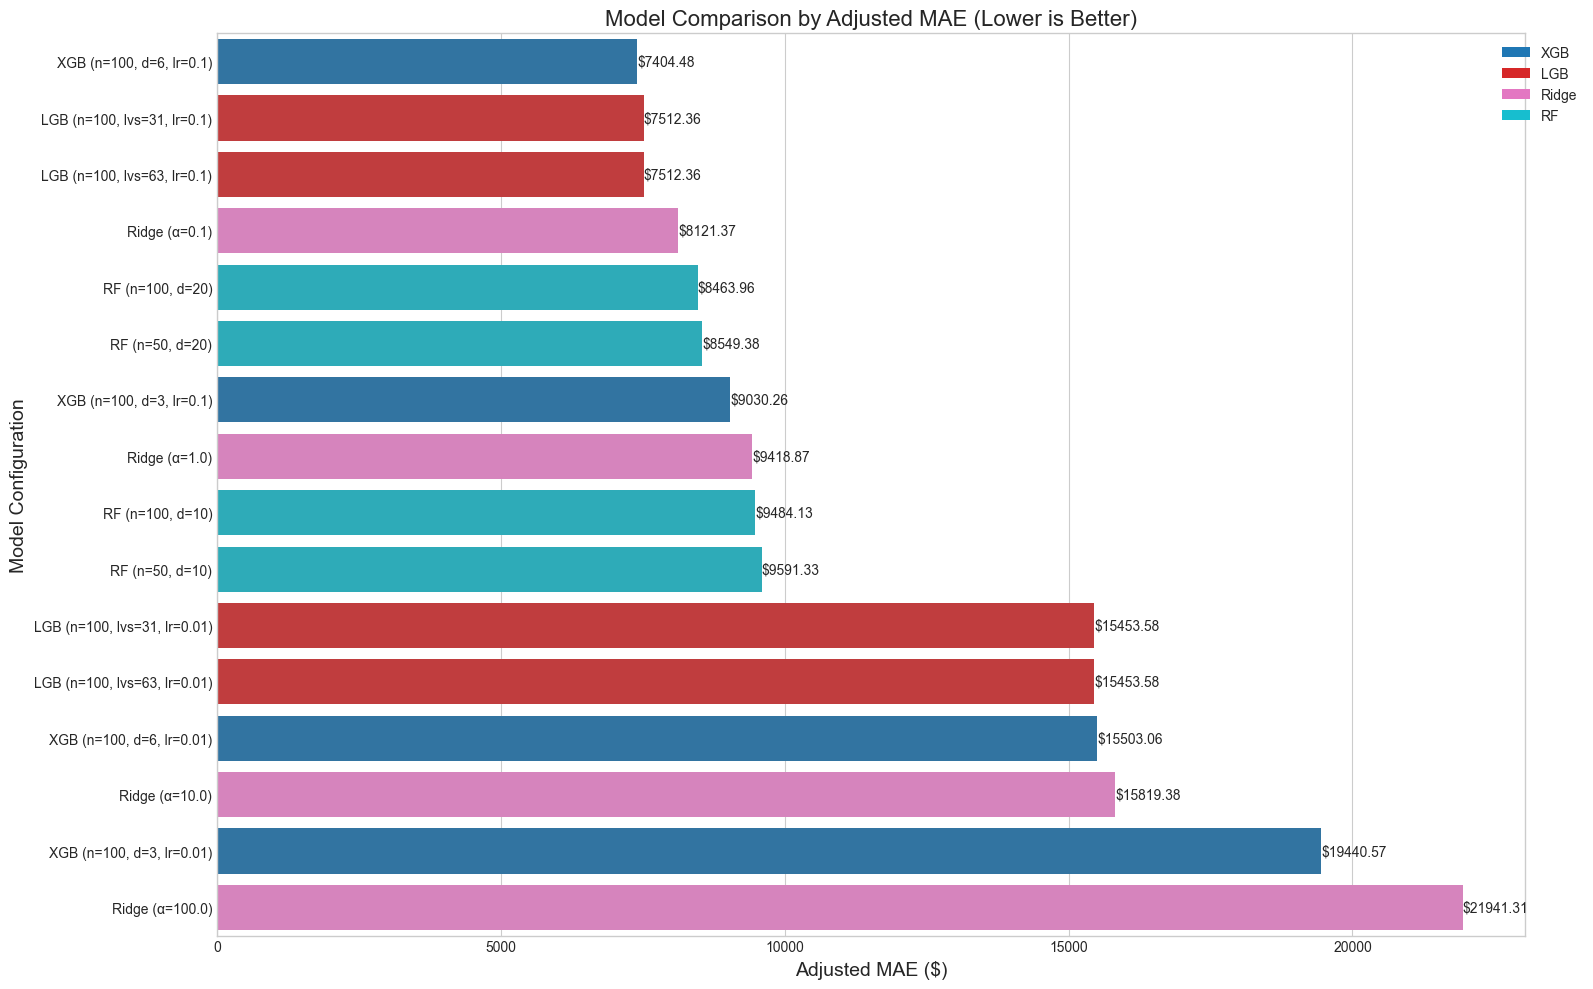

C:\Users\Sarthak\AppData\Local\Temp\ipykernel_11700\2994243279.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Within_10%', y='Model', data=within_10_df, palette=within_10_colors)


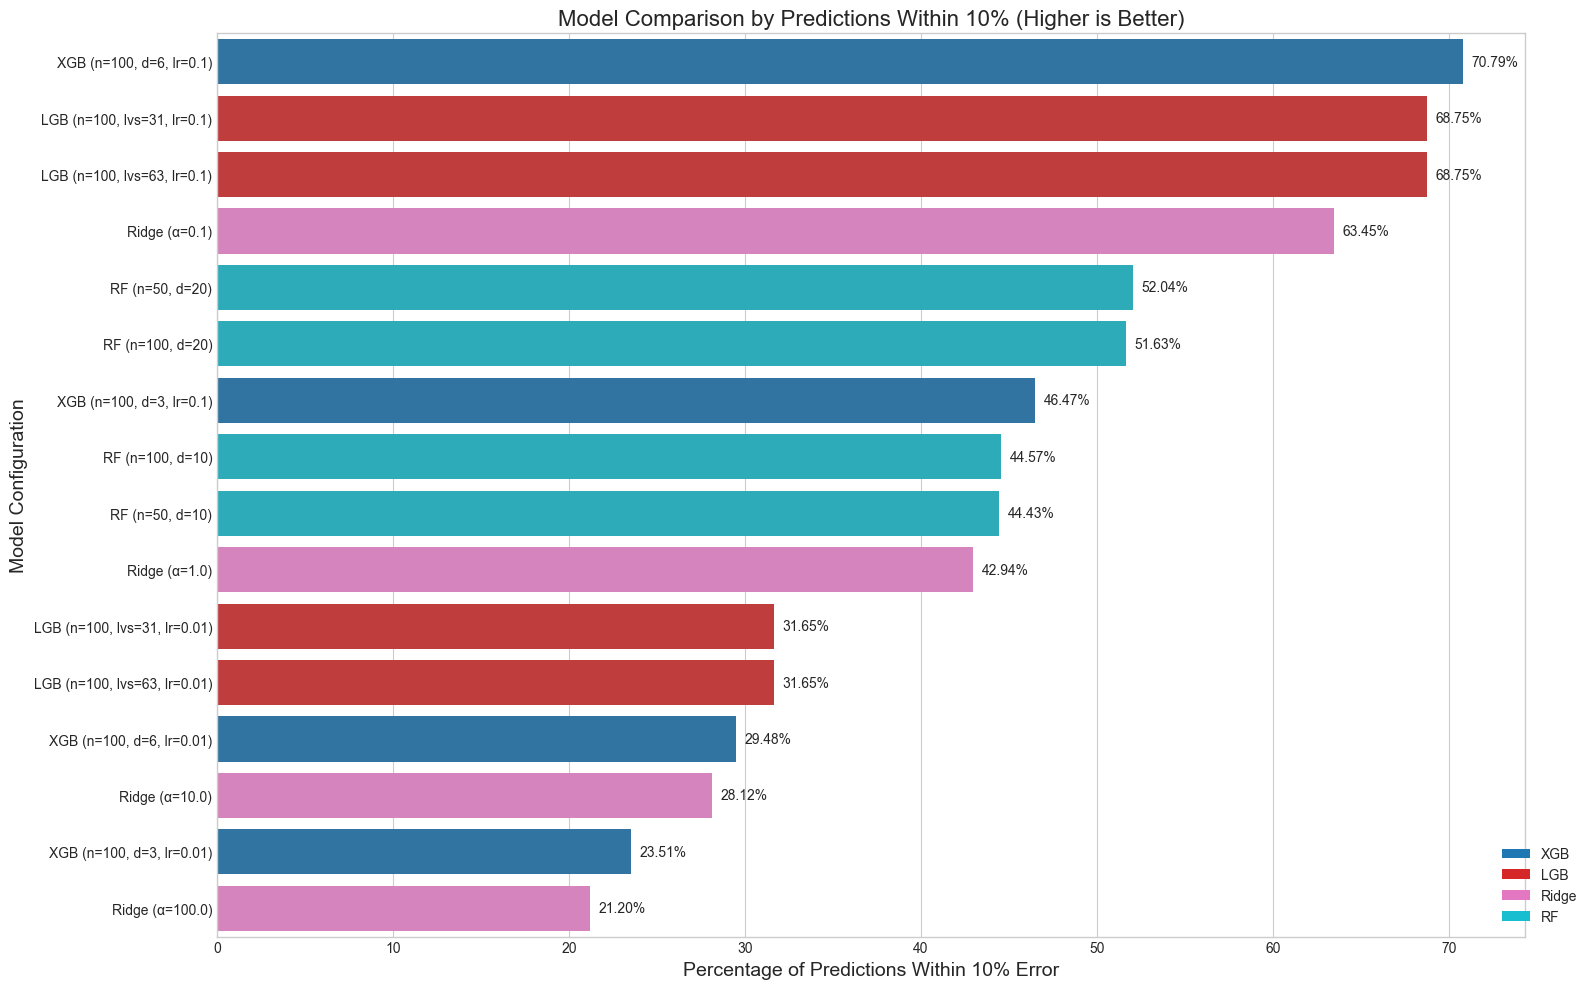

C:\Users\Sarthak\AppData\Local\Temp\ipykernel_11700\2994243279.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='R2', y='Model', data=r2_df, palette=r2_colors)


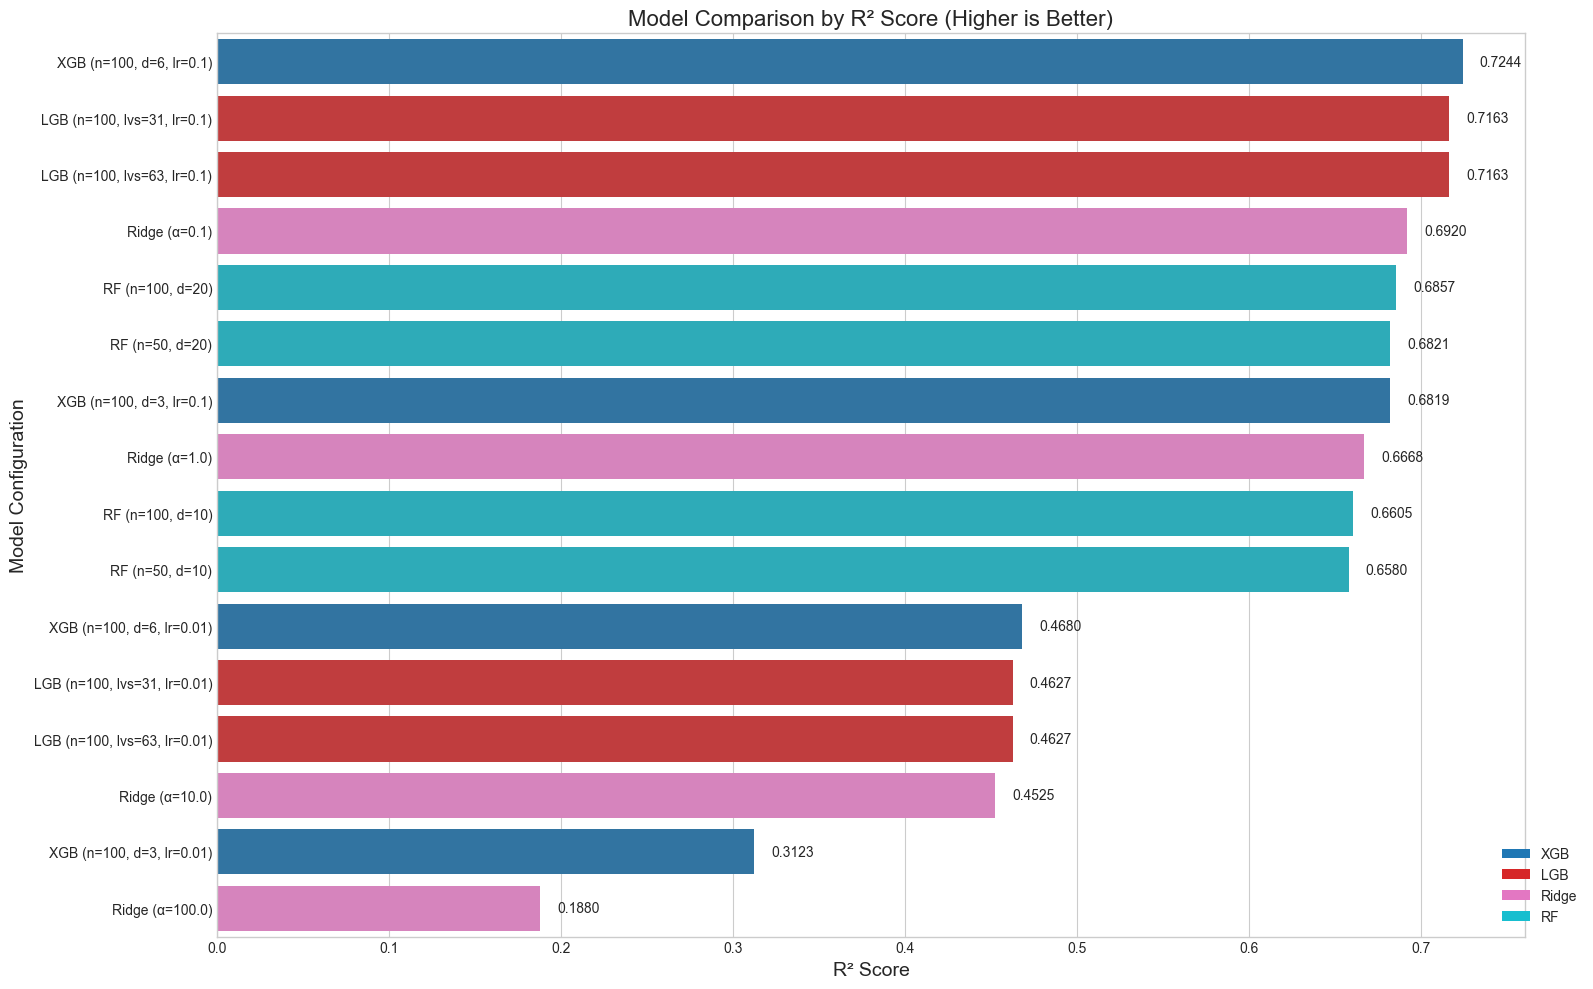


===== BEST MODELS =====
Best model by Adjusted MAE: XGB (n=100, d=6, lr=0.1)
Best model by Within 10%: XGB (n=100, d=6, lr=0.1)
Best model by R²: XGB (n=100, d=6, lr=0.1)

===== EXTREME ERROR ANALYSIS =====

Analyzing extreme errors for the best model: XGB (n=100, d=6, lr=0.1)
Number of extreme errors (>95th percentile): 37
Error threshold: $53505.29

Summary statistics for extreme errors:
              Actual      Predicted          Error      Abs_Error  \
count      37.000000      37.000000      37.000000      37.000000   
mean   172533.527027  137075.968750   35457.563345   78276.658784   
std     65941.648019   27565.847656   73725.242097   20739.747572   
min     51903.000000   76387.359375 -120499.437500   53775.781250   
25%    105777.000000  117044.218750  -54857.375000   61320.328125   
50%    193158.000000  137141.078125   64916.234375   73363.531250   
75%    226008.000000  157149.765625   83610.921875   90200.000000   
max    259843.500000  203938.437500  124457.828125  12

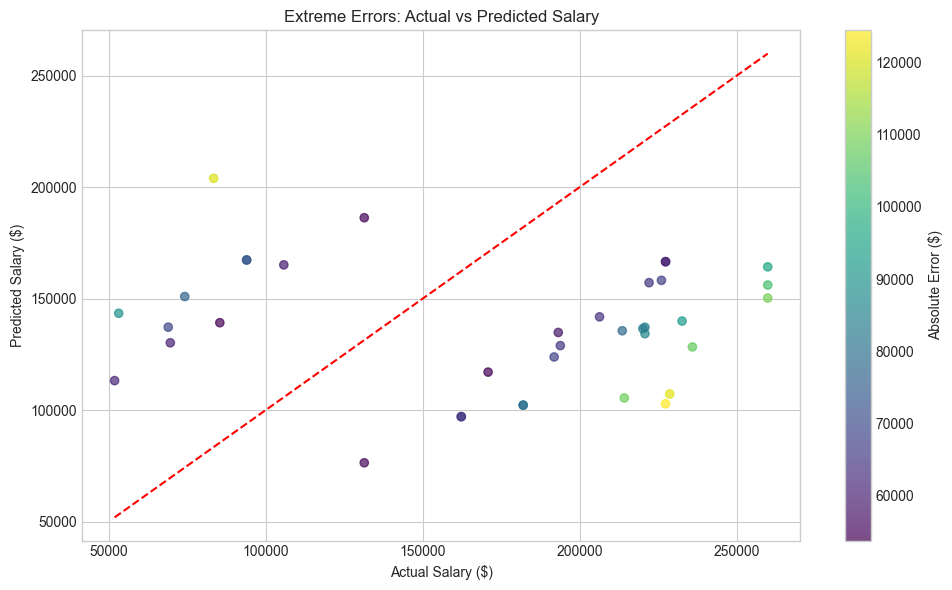

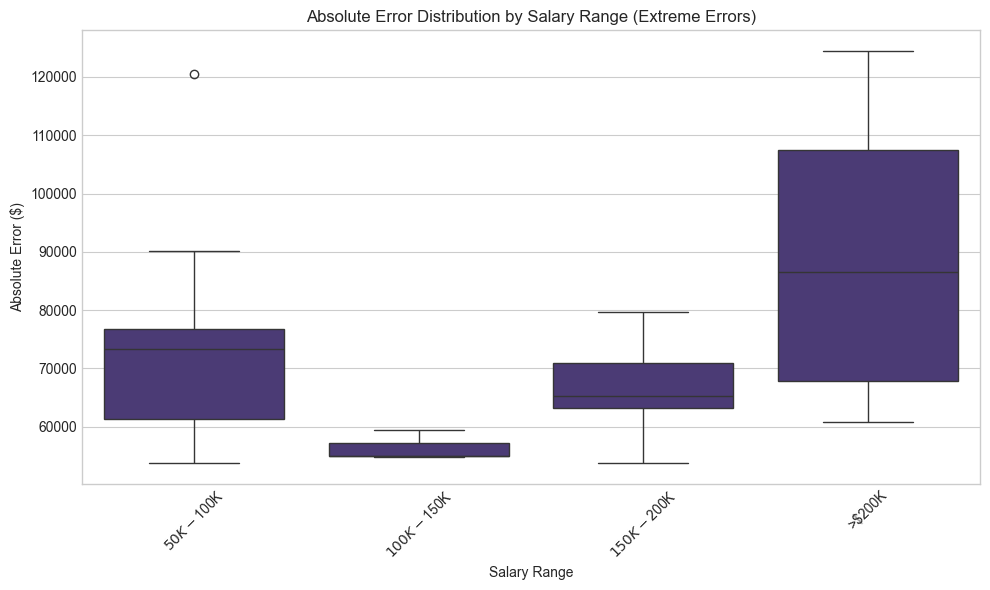


===== EVALUATION SUMMARY =====
The best overall model is: XGB (n=100, d=6, lr=0.1)
  Adjusted MAE: $7404.48
  Within 10%: 70.79%
  R²: 0.7244

Top 5 best performing models (by Adjusted MAE):


,Model,Adjusted_MAE,Adjusted_MAE_std,Within_10%,R2,Model_Type
7,"XGB (n=100, d=6, lr=0.1)",7404.478617,1173.607577,70.786909,0.724358,XGB
9,"LGB (n=100, lvs=31, lr=0.1)",7512.359790,1076.484574,68.749770,0.716341,LGB
11,"LGB (n=100, lvs=63, lr=0.1)",7512.359790,1076.484574,68.749770,0.716341,LGB
0,Ridge (α=0.1),8121.373861,955.175312,63.452841,0.692026,Ridge
15,"RF (n=100, d=20)",8463.960441,1145.454533,51.634492,0.685678,RF


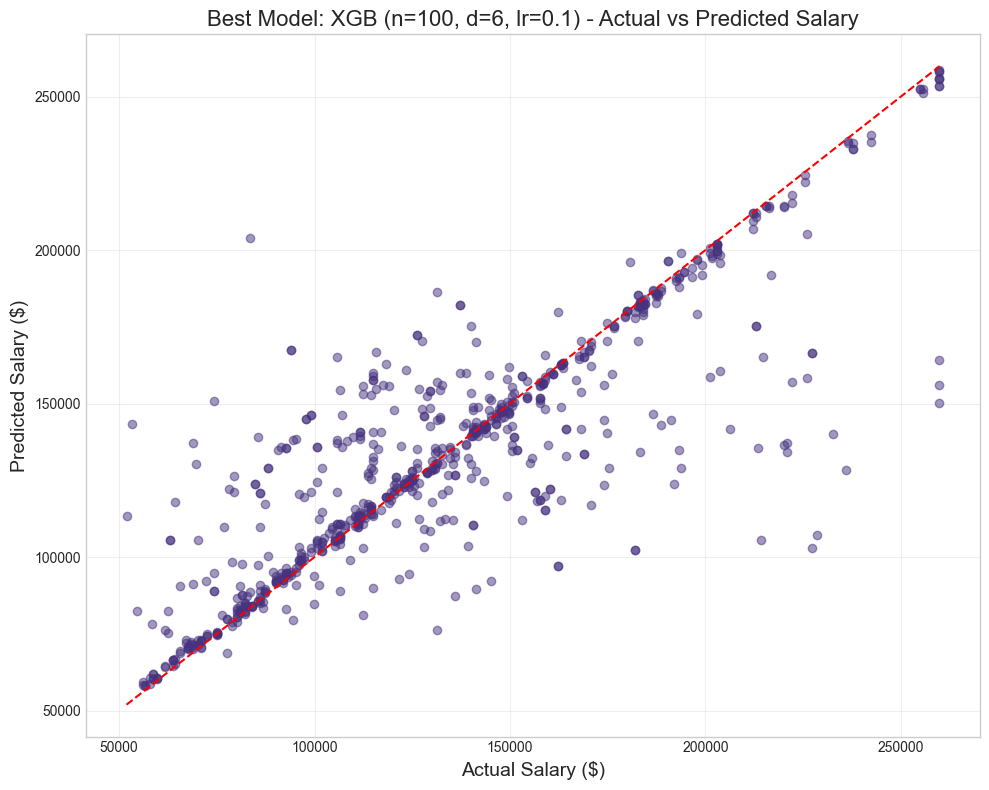

In [ ]:
# Execute the complete evaluation strategy
print("Starting comprehensive model evaluation...")
ablation_results, results_df, extreme_errors_df = complete_evaluation_strategy(X, y_avg)

# Display the top 5 best models
print("\nTop 5 best performing models (by Adjusted MAE):")
display(results_df.head(5))

# Plot actual vs predicted for the best model
best_model_name = results_df.iloc[0]['Model']
best_model_results = ablation_results[best_model_name]

plt.figure(figsize=(10, 8))
plt.scatter(best_model_results['actuals'], best_model_results['predictions'], alpha=0.5)
plt.plot([min(best_model_results['actuals']), max(best_model_results['actuals'])], 
         [min(best_model_results['actuals']), max(best_model_results['actuals'])], 'r--')
plt.title(f'Best Model: {best_model_name} - Actual vs Predicted Salary', fontsize=16)
plt.xlabel('Actual Salary ($)', fontsize=14)
plt.ylabel('Predicted Salary ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Analysis on Dataset

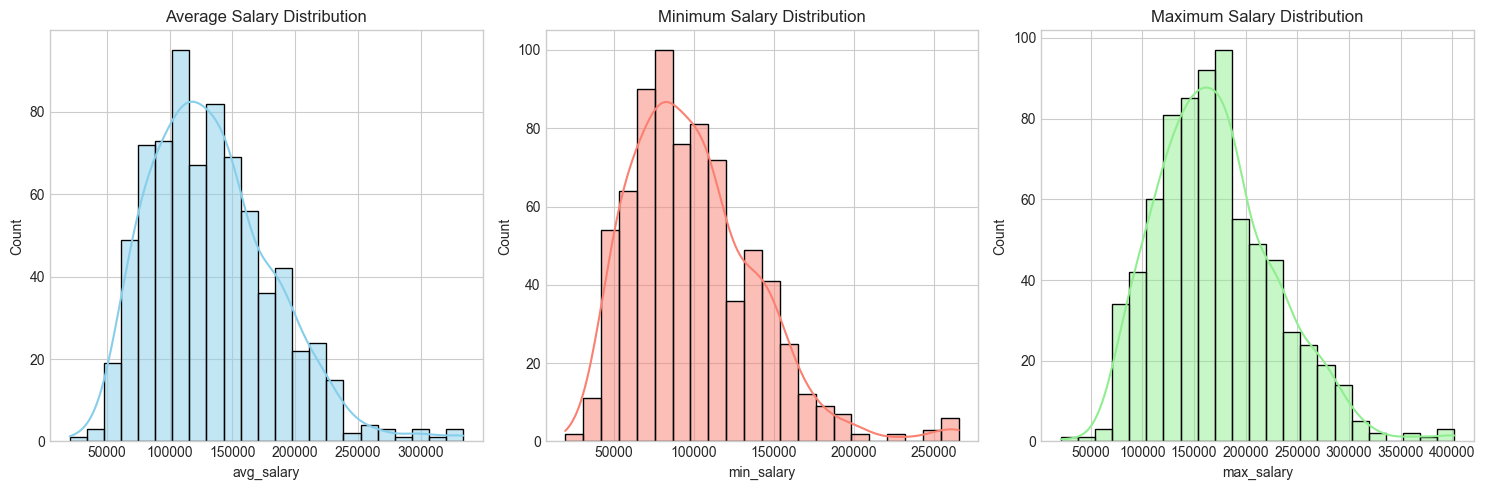

In [62]:
data = pd.read_csv('processed_data/glassdoor_jobs.csv')

# Salary distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['avg_salary'], kde=True, color='skyblue')
plt.title('Average Salary Distribution')

plt.subplot(1, 3, 2)
sns.histplot(data['min_salary'], kde=True, color='salmon')
plt.title('Minimum Salary Distribution')

plt.subplot(1, 3, 3)
sns.histplot(data['max_salary'], kde=True, color='lightgreen')
plt.title('Maximum Salary Distribution')
plt.tight_layout()
plt.show()

In [63]:
# Correlation matrix for key features
numerical_features = ['age', 'Python', 'R', 'Spark', 'AWS', 'Excel', 
                     'min_salary', 'max_salary', 'avg_salary', 'age_of_company_normalized']
corr_matrix = data[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

KeyError: "['age_of_company_normalized'] not in index"

/var/folders/xm/xvxkb40523x8s_fn2xy0f1900000gn/T/ipykernel_43348/394528867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importances, palette='viridis')


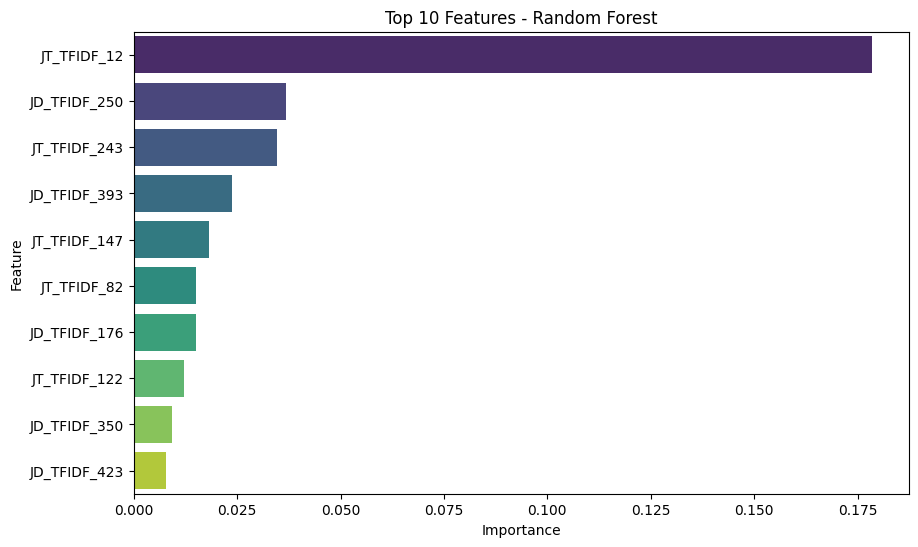

/var/folders/xm/xvxkb40523x8s_fn2xy0f1900000gn/T/ipykernel_43348/394528867.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_importances, palette='magma')


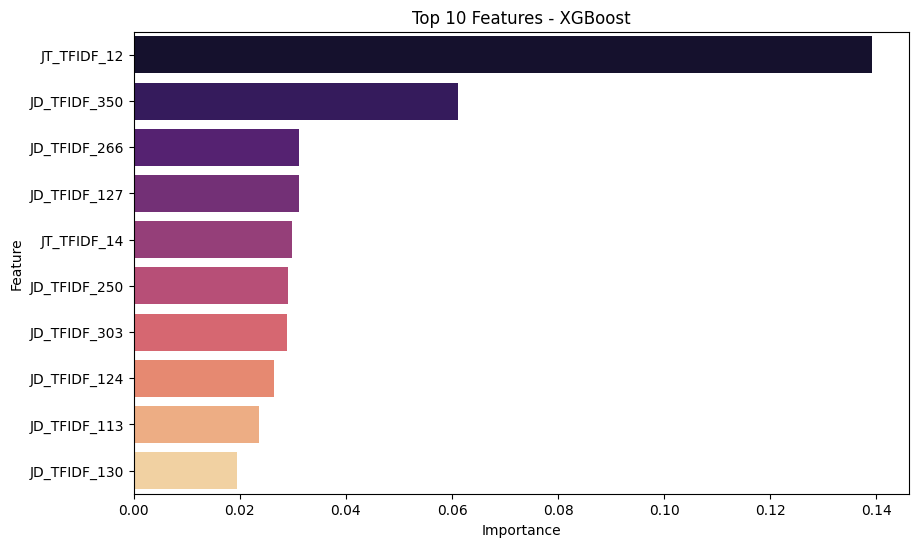

In [ ]:
# Random Forest Feature Importance
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances, palette='viridis')
plt.title('Top 10 Features - Random Forest')
plt.show()

# XGBoost Feature Importance
xgb_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importances, palette='magma')
plt.title('Top 10 Features - XGBoost')
plt.show()